In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils
from whittaker_smooth import whittaker_smooth
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

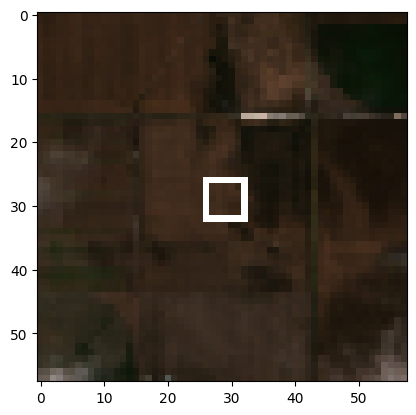

In [47]:
IMGS_PATH = '/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba1-1/'
bands =  ['B4','B3','B2','B8']

# Dict of the images.
images = utils.load_landsat_image(IMGS_PATH, bands)

# Get the days after plant and the dates.
days, dates, hours = utils.images_time_info(images.keys())

# Calculate the NDVI series over the crop.
ndvi_series = utils.generate_ndvi_time_series(images)

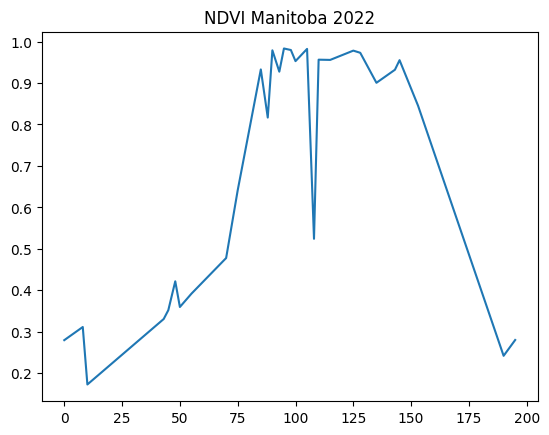

In [48]:
plt.plot(days, ndvi_series)
plt.title('NDVI Manitoba 2022')
plt.show()

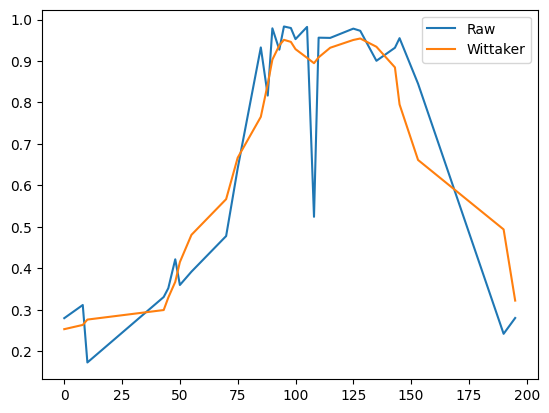

In [49]:
# Perform a Whittaker Smooth.
y_ = whittaker_smooth(np.array(ndvi_series), lmbd=10)
plt.plot(days, ndvi_series, label="Raw")
plt.plot(days, y_, label='Wittaker')
plt.legend()
plt.show()

In [50]:
df = pd.DataFrame(columns=["Dates", "Values"])
df["Dates"] = pd.to_datetime(dates)
df["Values"] = y_
df = df.resample('1D', on="Dates").agg("first").ffill() ## Quitar para eliminar resampling
df

,Values
Dates,
2019-04-16,0.253138
2019-04-17,0.253138
2019-04-18,0.253138
2019-04-19,0.253138
2019-04-20,0.253138
...,...
2019-10-24,0.493792
2019-10-25,0.493792
2019-10-26,0.493792


<AxesSubplot: xlabel='Dates'>

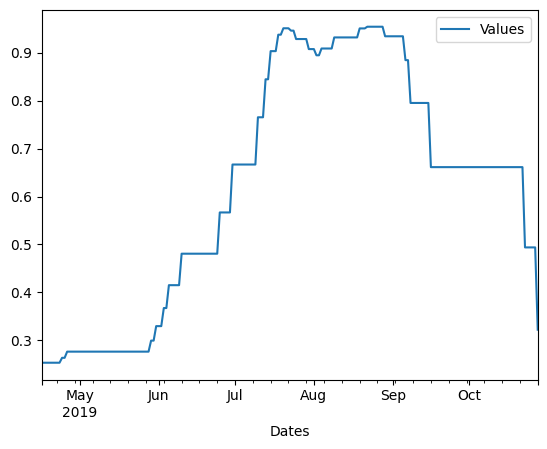

In [51]:
df.plot()

## Train/Test

In [52]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(np.asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

>expected=0.7, predicted=0.7
>expected=0.7, predicted=0.7
>expected=0.7, predicted=0.7
>expected=0.7, predicted=0.7
>expected=0.7, predicted=0.7
>expected=0.7, predicted=0.7
>expected=0.5, predicted=0.7
>expected=0.5, predicted=0.6
>expected=0.5, predicted=0.5
>expected=0.5, predicted=0.5
>expected=0.5, predicted=0.5
>expected=0.3, predicted=0.5
MAE: 0.035


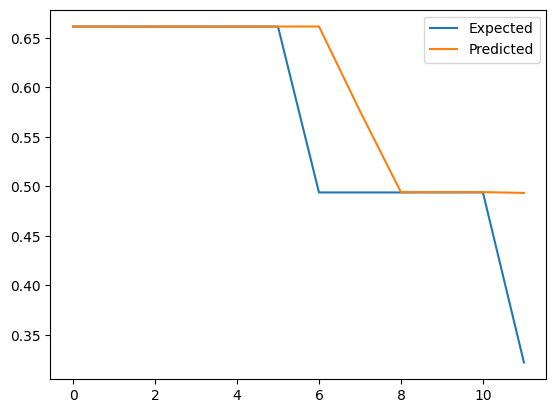

In [53]:
# load the dataset
values = list(df["Values"])
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [54]:
y_

array([0.25313787, 0.26337365, 0.2762652 , 0.29927465, 0.32951529,
       0.36724413, 0.41497486, 0.48066594, 0.56674687, 0.66676366,
       0.76536586, 0.84464046, 0.90341205, 0.93770995, 0.95111471,
       0.94617289, 0.92865362, 0.90766954, 0.89474945, 0.90888587,
       0.93201543, 0.95081863, 0.95435082, 0.93440029, 0.88461359,
       0.79525072, 0.66131297, 0.49379209, 0.32207328])

## Forecast

In [55]:
# load the dataset
values = list(df["Values"])
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=90)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

predictions = []

for i in range(300):
# construct an input for a new preduction
    row = values[-90:]
# make a one-step prediction
    yhat = model.predict(np.asarray([row]))
    values.append(yhat[0])
    predictions.append(yhat[0])
    #print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

In [56]:
predictions

[0.3234045,
 0.6039879,
 0.6039879,
 0.6039879,
 0.6039879,
 0.6039879,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.6611611,
 0.79244447,
 0.79244447,
 0.79244447,
 0.79244447,
 0.79244447,
 0.79244447

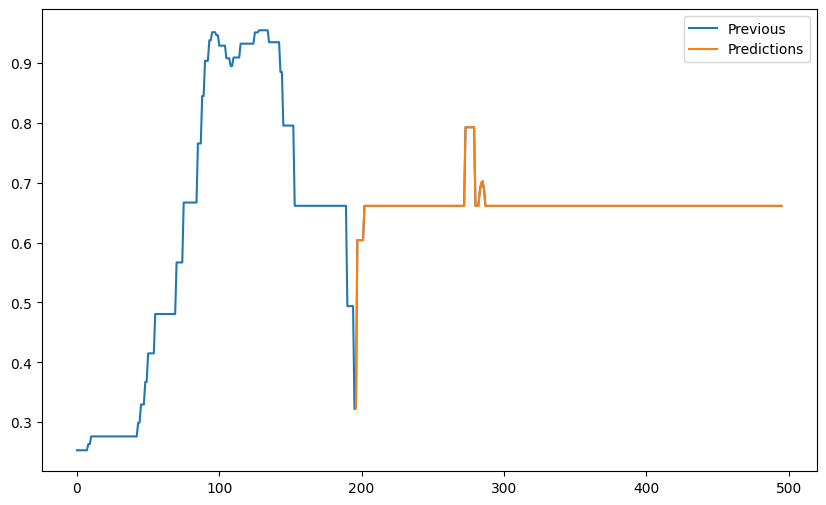

In [57]:
plt.figure(figsize=(10,6))
plt.plot([i for i in range(len(values))], values, label="Previous")
plt.plot([i for i in range(len(df["Values"]), len(df["Values"])+len(predictions))], predictions, label="Predictions")
plt.legend()
plt.show()

# Interpolation

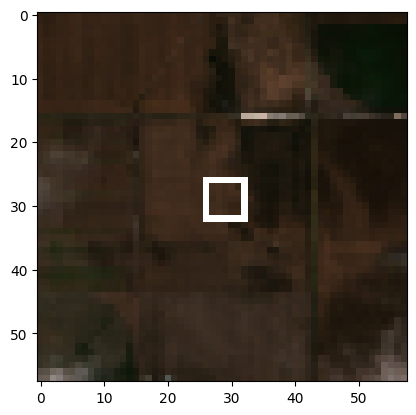

In [58]:
IMGS_PATH = '/home/mauricio/code/Plant-Growth-Cycle-based-on-geospatial-data/Manitoba1-1/'
bands =  ['B4','B3','B2','B8']

# Dict of the images.
images = utils.load_landsat_image(IMGS_PATH, bands)

# Get the days after plant and the dates.
days, dates, hours = utils.images_time_info(images.keys())

# Calculate the NDVI series over the crop.
ndvi_series = utils.generate_ndvi_time_series(images)

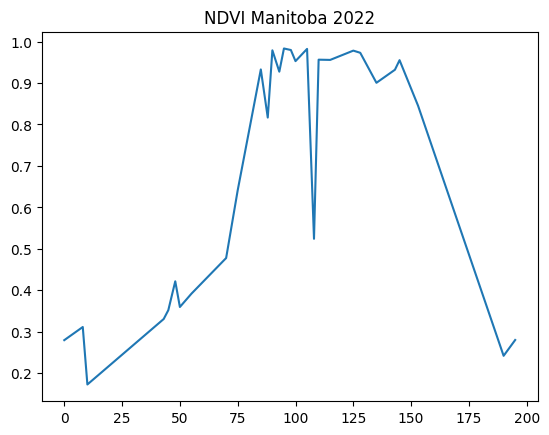

In [59]:
plt.plot(days, ndvi_series)
plt.title('NDVI Manitoba 2022')
plt.show()

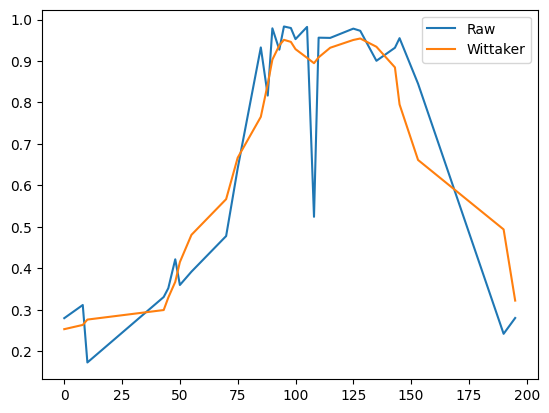

In [60]:
# Perform a Whittaker Smooth.
smoothed = whittaker_smooth(np.array(ndvi_series), lmbd=10)
plt.plot(days, ndvi_series, label="Raw")
plt.plot(days, smoothed, label='Wittaker')
plt.legend()
plt.show()

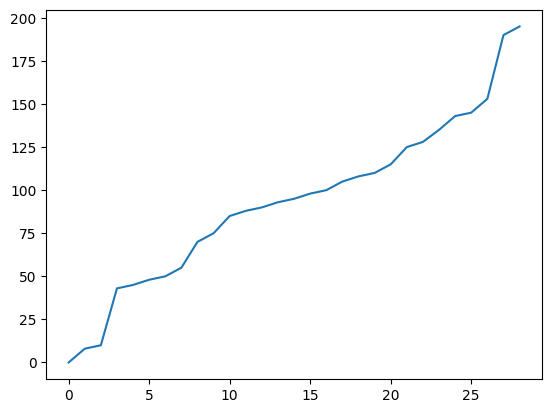

In [61]:
plt.plot(days)

In [62]:
x_new, y_new = utils.interpolate_curve(days, smoothed)
    

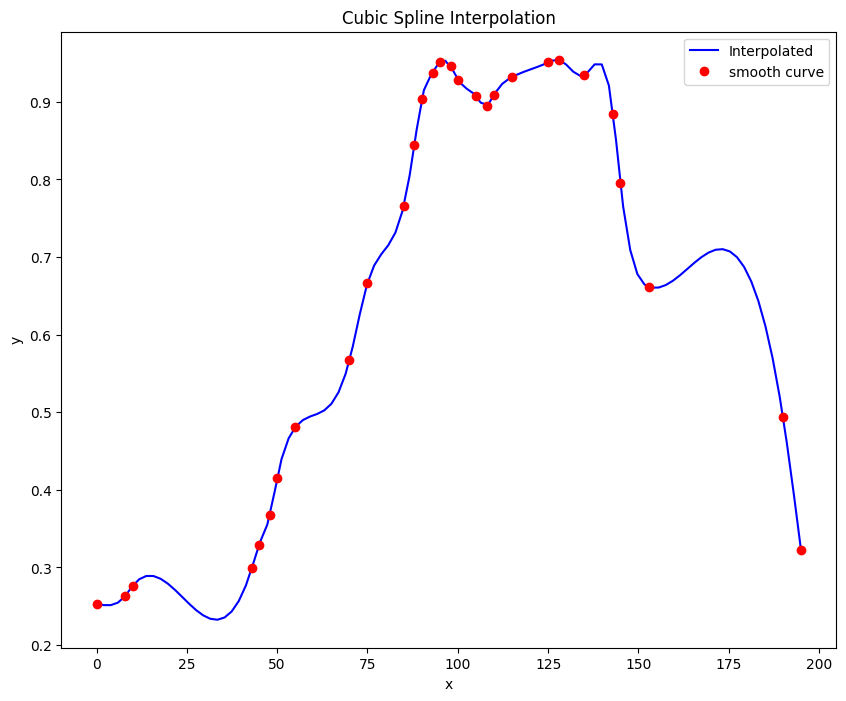

In [63]:
plt.figure(figsize = (10,8))
plt.plot(x_new, y_new, 'b', label='Interpolated')
plt.plot(days, smoothed, 'ro', label='smooth curve')
plt.title('Cubic Spline Interpolation')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [69]:
# load the dataset
values = list(y_new)
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=60)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

predictions = []

for i in range(1000):
# construct an input for a new preduction
    row = values[-60:]
# make a one-step prediction
    yhat = model.predict(np.asarray([row]))
    values.append(yhat[0])
    predictions.append(yhat[0])
    #print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

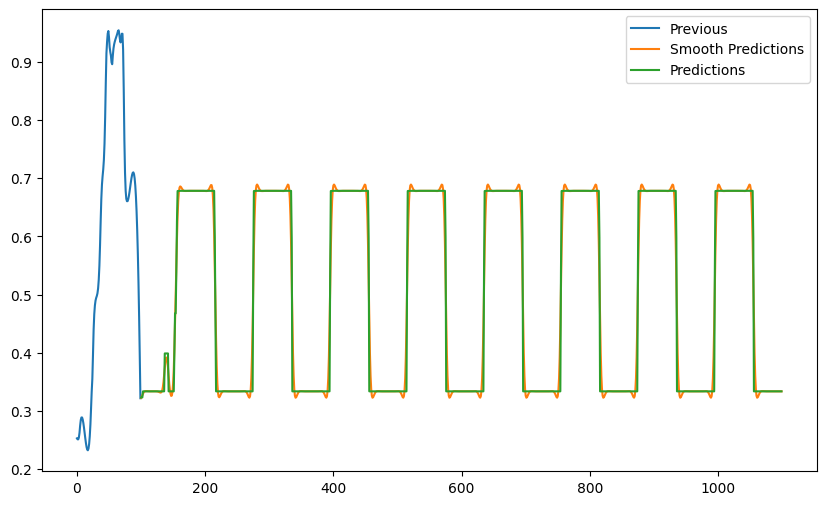

In [70]:
o = whittaker_smooth(np.array(predictions), lmbd=10)
plt.figure(figsize=(10,6))
plt.plot([i for i in range(len(y_new))], y_new, label="Previous")
plt.plot([i for i in range(len(y_new), len(y_new)+len(predictions))], o, label="Smooth Predictions")
plt.plot([i for i in range(len(y_new), len(y_new)+len(predictions))], predictions, label="Predictions")

plt.legend()
plt.show()